In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Display 'measurement' columns
measurement_inspector = inspect(engine)
columns = measurement_inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
with engine.connect() as conn:
    print(conn.execute(text('SELECT * FROM Measurement LIMIT 5')).fetchall())

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]


In [68]:
# Find the most recent date in the data set.
# most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date


'2017-08-23'

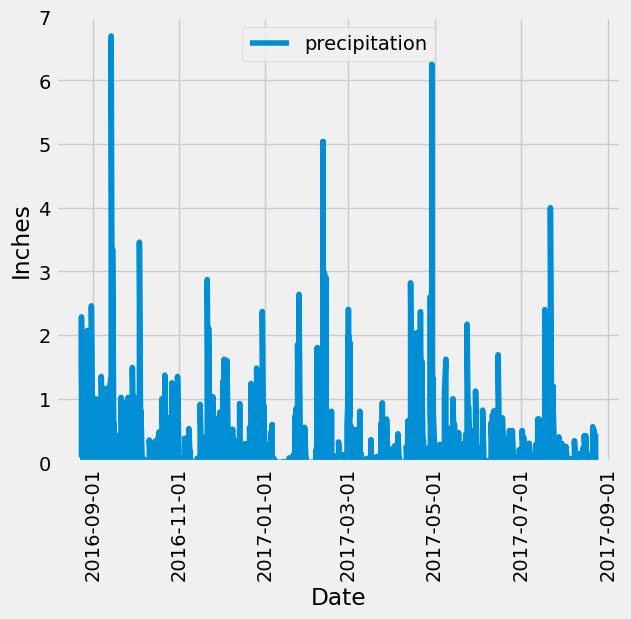

In [98]:
import matplotlib.dates as mdates
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
last_year = dt.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_results = pd.DataFrame(results)
prcp_results.rename(columns={'date': 'Date', 'prcp':'Precipitation'}, inplace=True)
prcp_results = prcp_results.dropna()

# Sort the dataframe by date
prcp_results.sort_values('Date')
prcp_results['Date'] = [dt.strptime(date, '%Y-%m-%d') for date in prcp_results['Date']]  

#Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6.5,5.5))
plt.plot(prcp_results['Date'], prcp_results['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylim(0, 7)
plt.legend(['precipitation'], loc='upper center')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prcp_results['Precipitation'].describe()
summary_statistics_df = pd.DataFrame(summary_statistics)
summary_statistics_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Display 'measurement' columns
station_inspector = inspect(engine)
columns = station_inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
with engine.connect() as conn:
    print(conn.execute(text('SELECT * FROM Station')).fetchall())

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(Measurement.station))).all()

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.station)
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
low_high_avg_temp = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
    ).filter(Measurement.station == most_active_station).all()
low_high_avg_temp

[(54.0, 85.0, 71.66378066378067)]

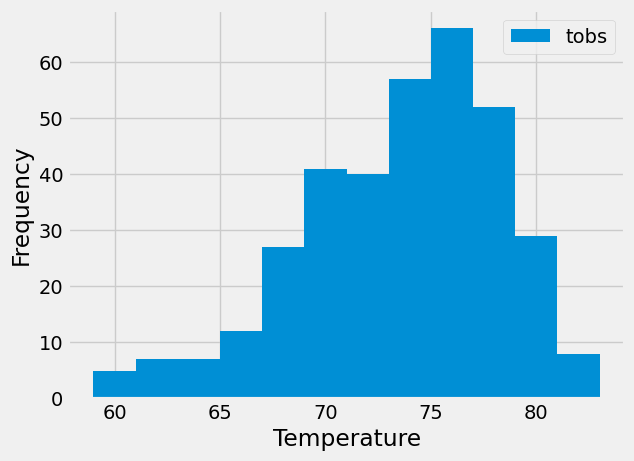

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date for this station.
most_active_station_recent_date = session.query(func.max(Measurement.date)).scalar()
most_active_station_last_12_months = dt.strptime(most_active_station_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the last 12 months of temperature observation data for this station 
last_12_months_temps = session.query(Measurement.tobs).filter(
    Measurement.station == 'USC00519281',
    Measurement.date >= most_active_station_last_12_months
).all()

# Save the query results as a Pandas DataFrame
most_active_station_last_12_months_tobs = pd.DataFrame(last_12_months_temps)

# Plot the results as a histogram
most_active_station_last_12_months_tobs.plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='upper right')
plt.show()

# Close Session

In [20]:
# Close Session
session.close()